In [10]:
from utils.utils import *
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = load_csv()

In [4]:
#Normalize data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [15]:
# No missing samples
len(df)-df.count()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [22]:
target_col = "Outcome"
train_cols = [c for c in df.columns if c!= target_col]

x = df[train_cols].values

#Normalizing as Knearest is sensible to scale
x =(x-x.mean(axis=0))/x.std(axis=0)

y = df[target_col].values

In [25]:
np.shape(x)

(768, 8)

In [26]:
#Seeing the class imbalance
vals, counts = np.unique(df['Outcome'], return_counts=True)
print(vals, counts/len(df))

[0 1] [0.65104167 0.34895833]


In [27]:
rf = RandomForest(100)
rf.fit(x,y)
preds_rf = rf.predict_proba(x)

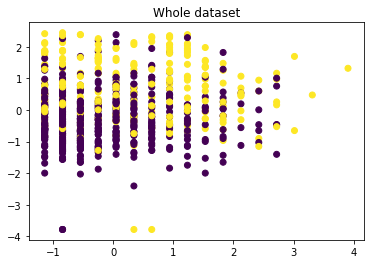

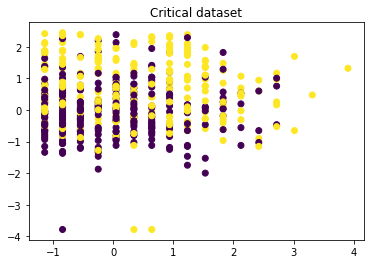

In [29]:
#Debug plots the original and the critical dataset
# 3 neighbors example
brf = BiasedRandomForest(debug=True,k=3,p=0.5)
brf.fit(x,y)
preds_brf = brf.predict_proba(x)

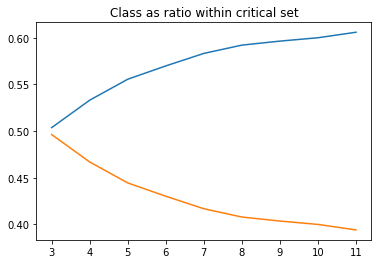

In [30]:
cat_ratio = []
k_range = range(3,12)
for k in k_range:
    brf = BiasedRandomForest(debug=False,n_trees=1,k=k,p=0.5)
    brf.fit(x,y)
    values, counts = np.unique(y[brf.critical_ixs],return_counts=True)
    cat_ratio.append(counts/len(brf.critical_ixs))
    
plt.plot(list(k_range),np.array(cat_ratio))
plt.title("Class as ratio within critical set")
plt.show()

In [31]:
brf_dict = {"Accuracy":[],"Precision":[],"Recall":[],"TPR":[],"FPR":[],"PR-Curve":[],"ROC-Curve":[],"AU-ROC":[],"AU-PRC":[]}
rf_dict = {"Accuracy":[],"Precision":[],"Recall":[],"TPR":[],"FPR":[],"PR-Curve":[],"ROC-Curve":[],"AU-ROC":[],"AU-PRC":[]}

brf_dict_train = {"Accuracy":[],"Precision":[],"Recall":[],"TPR":[],"FPR":[],"PR-Curve":[],"ROC-Curve":[],"AU-ROC":[],"AU-PRC":[]}
rf_dict_train = {"Accuracy":[],"Precision":[],"Recall":[],"TPR":[],"FPR":[],"PR-Curve":[],"ROC-Curve":[],"AU-ROC":[],"AU-PRC":[]}
#
K = 4
p = 0.3
s = 50
n_folds = 5
indexes = stratified_k_fold(x, y, n_folds=n_folds, shuffle=True,seed=99)
for ixs in range(n_folds):
    test_index = indexes==ixs
    train_index = ~test_index
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf = RandomForest(s)
    rf.fit(X_train,y_train)
    
    ## EVAL ON TRAIN
    preds_rf = rf.predict_proba(X_train)
    precision, recall, pr_auc = precision_recall(preds_rf, y_train)
    tpr, fpr, roc_auc = tpr_fpr(preds_rf, y_train)
    
    pred_round = preds_rf.copy()
    pred_round[pred_round>=0.5]=1
    pred_round[pred_round<0.5]=0
    
    rf_dict_train['Accuracy'].append(accuracy(pred_round,y_train))
    rf_dict_train['Precision'].append(precision[50])
    rf_dict_train['Recall'].append(recall[50])
    rf_dict_train['TPR'].append(tpr)
    rf_dict_train['FPR'].append(fpr)
    rf_dict_train['PR-Curve'].append((recall, precision))
    rf_dict_train['ROC-Curve'].append((fpr, tpr))
    rf_dict_train['AU-PRC'].append(pr_auc)
    rf_dict_train['AU-ROC'].append(roc_auc)
    
    ## EVAL ON VAL
    preds_rf = rf.predict_proba(X_test)
    
    precision, recall, pr_auc = precision_recall(preds_rf, y_test)
    tpr, fpr, roc_auc = tpr_fpr(preds_rf, y_test)
    
    pred_round = preds_rf.copy()
    pred_round[pred_round>=0.5]=1
    pred_round[pred_round<0.5]=0
    
    rf_dict['Accuracy'].append(accuracy(pred_round,y_test))
    rf_dict['Precision'].append(precision[50])
    rf_dict['Recall'].append(recall[50])
    rf_dict['TPR'].append(tpr)
    rf_dict['FPR'].append(fpr)
    rf_dict['PR-Curve'].append((recall, precision))
    rf_dict['ROC-Curve'].append((fpr, tpr))
    rf_dict['AU-PRC'].append(pr_auc)
    rf_dict['AU-ROC'].append(roc_auc)
    
    ## EVAL ON TRAIN
    brf = BiasedRandomForest(debug=False,n_trees=s, p=p, k=K)
    brf.fit(X_train,y_train)
    preds_brf = brf.predict_proba(X_train)
        
    precision, recall, pr_auc = precision_recall(preds_brf, y_train)
    tpr, fpr, roc_auc = tpr_fpr(preds_brf, y_train)
    
    pred_round = preds_brf.copy()
    pred_round[pred_round>=0.5]=1
    pred_round[pred_round<0.5]=0
    
    brf_dict_train['Accuracy'].append(accuracy(pred_round,y_train))
    brf_dict_train['Precision'].append(precision[50])
    brf_dict_train['Recall'].append(recall[50])
    brf_dict_train['TPR'].append(tpr)
    brf_dict_train['FPR'].append(fpr)
    brf_dict_train['PR-Curve'].append((recall, precision))
    brf_dict_train['ROC-Curve'].append((fpr, tpr))
    brf_dict_train['AU-PRC'].append(pr_auc)
    brf_dict_train['AU-ROC'].append(roc_auc)
    
    
    ## EVAL on TEST
    preds_brf = brf.predict_proba(X_test)
        
    precision, recall, pr_auc = precision_recall(preds_brf, y_test)
    tpr, fpr, roc_auc = tpr_fpr(preds_brf, y_test)
    
    pred_round = preds_brf.copy()
    pred_round[pred_round>=0.5]=1
    pred_round[pred_round<0.5]=0
    
    brf_dict['Accuracy'].append(accuracy(pred_round,y_test))
    brf_dict['Precision'].append(precision[50])
    brf_dict['Recall'].append(recall[50])
    brf_dict['TPR'].append(tpr)
    brf_dict['FPR'].append(fpr)
    brf_dict['PR-Curve'].append((recall, precision))
    brf_dict['ROC-Curve'].append((fpr, tpr))
    brf_dict['AU-PRC'].append(pr_auc)
    brf_dict['AU-ROC'].append(roc_auc)

/Users/ravikumar/Downloads/ML_Technical/utils/utils.py:86: RuntimeWarning: invalid value encountered in long_scalars
  pr = tp / (tp + fp)


In [32]:
brf_results = pd.DataFrame(brf_dict)
brf_results_train = pd.DataFrame(brf_dict_train)

In [33]:
brf_results_train[["Accuracy","Precision","Recall","AU-ROC","AU-PRC"]].mean(axis=0)

Accuracy     86.587696
Precision     0.836142
Recall        0.769541
AU-ROC       -0.942999
AU-PRC       -0.900712
dtype: float64

In [34]:
brf_results[["Accuracy","Precision","Recall","AU-ROC","AU-PRC"]].mean(axis=0)

Accuracy     75.379849
Precision     0.666404
Recall        0.619287
AU-ROC       -0.828427
AU-PRC       -0.681064
dtype: float64

In [35]:
rf_results = pd.DataFrame(rf_dict)
rf_results_train = pd.DataFrame(rf_dict_train)

In [36]:
rf_results_train[["Accuracy","Precision","Recall","AU-ROC","AU-PRC"]].mean(axis=0)

Accuracy     86.587696
Precision     0.832279
Recall        0.772341
AU-ROC       -0.941497
AU-PRC       -0.897335
dtype: float64

In [37]:
rf_results[["Accuracy","Precision","Recall","AU-ROC","AU-PRC"]].mean(axis=0)

Accuracy     75.641287
Precision     0.672580
Recall        0.611880
AU-ROC       -0.827883
AU-PRC       -0.688063
dtype: float64

In [38]:
# rf_dict['PR-Curve'].append((recall, precision))
# rf_dict['ROC-Curve'].append((fpr, tpr))
def extract_feats(feat_dict, curve='PR-Curve'):    
    mean_0 =  np.mean([e[0] for e in feat_dict[curve]],axis=0)
    std_0 =  np.std([e[0] for e in feat_dict[curve]],axis=0)
    mean_1 =  np.mean([e[1] for e in feat_dict[curve]],axis=0)
    std_1 =  np.std([e[1] for e in feat_dict[curve]],axis=0)
    return mean_0, std_0, mean_1, std_1

def generate_plot(rf_dict, brf_dict):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    mean_recall,std_recall,mean_precision,std_precision = extract_feats(rf_dict,"PR-Curve")
    mean_pr_auc = np.trapz(x=mean_recall, y=mean_precision)

    axes[0].plot(mean_recall, mean_precision, color='b',
                 label=r'Mean PR (AUC = %0.2f' % (mean_pr_auc),
                 lw=2, alpha=.8)

    prec_upper = np.minimum(mean_precision + std_precision, 1)
    prec_lower = np.maximum(mean_precision - std_precision, 0)
    axes[0].fill_between(mean_recall, prec_lower, prec_upper, color='b', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    mean_recall,std_recall,mean_precision,std_precision = extract_feats(brf_dict,"PR-Curve")
    mean_pr_auc = np.trapz(x=mean_recall, y=mean_precision)

    axes[0].plot(mean_recall, mean_precision, color='r',
                 label=r'Mean PR (AUC = %0.2f' % (mean_pr_auc),
                 lw=2, alpha=.8)

    prec_upper = np.minimum(mean_precision + std_precision, 1)
    prec_lower = np.maximum(mean_precision - std_precision, 0)
    axes[0].fill_between(mean_recall, prec_lower, prec_upper, color='r', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    mean_fpr, std_fpr, mean_tpr, std_tpr = extract_feats(rf_dict,"ROC-Curve")
    mean_roc_auc = np.trapz(x=mean_fpr, y=mean_tpr)

    axes[1].plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f' % (mean_roc_auc),
                 lw=2, alpha=.8)

    #std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    axes[1].fill_between(mean_fpr, tpr_lower, tpr_upper, color='b', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    mean_fpr, std_fpr, mean_tpr, std_tpr = extract_feats(brf_dict,"ROC-Curve")
    mean_roc_auc = np.trapz(x=mean_fpr, y=mean_tpr)

    axes[1].plot(mean_fpr, mean_tpr, color='r',
                 label=r'Mean ROC (AUC = %0.2f' % (mean_roc_auc),
                 lw=2, alpha=.8)

    #std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    axes[1].fill_between(mean_fpr, tpr_lower, tpr_upper, color='r', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    axes[0].set_title("PR-AUC")
    axes[0].set_ylabel("Precision")
    axes[0].set_xlabel("Recall")
    axes[1].set_title("ROC-AUC")
    axes[1].set_ylabel("TPR")
    axes[1].set_xlabel("FPR")
    axes[0].legend(loc="lower right")
    axes[1].legend(loc="lower right")

    plt.show()

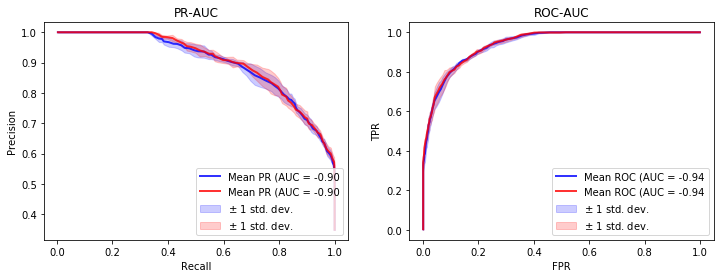

In [39]:
generate_plot(rf_dict_train,brf_dict_train)

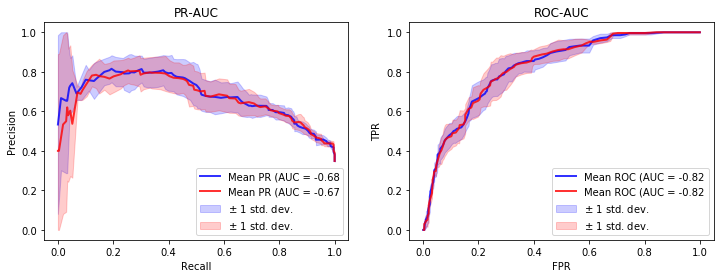

In [40]:
generate_plot(rf_dict,brf_dict)